# Visualization

> Necessary scripts to visualize orbits

In [37]:
#| default_exp visualize

In [38]:
#| export
#| hide
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.cm as cm
from matplotlib import colormaps
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from typing import Optional, List, Dict, Any, Union

In [39]:
#| hide
from pytest import raises

## Orbits

### Static

In [40]:
#| export
def visualize_static_orbits(data: np.ndarray,  # The orbit data with shape (num_orbits, 6, num_time_points).
                            time_instants: Optional[List[int]] = None,  # Time points to highlight; defaults to None.
                            orbit_indices: Optional[List[int]] = None,  # Indices of orbits to visualize; defaults to all.
                            point_dict: Optional[Dict[str, tuple]] = None,  # Dictionary of extra points to plot.
                            show_legend: bool = True,  # Flag to indicate whether to show a legend.
                            save_path: Optional[str] = None,  # Path to save the figure; defaults to None.
                            plot_reference_box: bool = True  # Flag to indicate whether to plot the reference box.
                           ) -> None:
    """
    Visualizes orbits in 3D space and highlights specified time instants for each selected orbit.
    """
    
    # Use Matplotlib's Computer Modern font
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif'],
        'font.size': 10,
        'text.usetex': False
    })

    if time_instants is None:
        time_instants = []  # Initialize to empty list if None.

    # Validate time instants are within the range of available time points.
    max_time_instants = data.shape[2]
    for time_instant in time_instants:
        if time_instant < 0 or time_instant >= max_time_instants:
            raise ValueError(f"Time instant {time_instant} is out of range.")

    # Validate orbit indices are within the range of available orbits.
    num_orbits = data.shape[0]
    if orbit_indices is None:
        orbit_indices = range(num_orbits)  # Use all orbits by default.
    else:
        for index in orbit_indices:
            if index < 0 or index >= num_orbits:
                raise ValueError(f"Orbit index {index} is out of range.")

    # Setup a 3D plot.
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each selected orbit.
    for index in orbit_indices:
        X = data[index, 0, :]  # X coordinates
        Y = data[index, 1, :]  # Y coordinates
        Z = data[index, 2, :]  # Z coordinates
        ax.plot(X, Y, Z, label=f'Orbit {index}', alpha=0.5)  # Plot each orbit with a label.

    # Generate a color map for time instants if they exist.
    colors = plt.cm.jet(np.linspace(0, 1, len(time_instants)))

    # Highlight specified time instants and add to the legend.
    legend_added = set()  # Track which labels have been added to the legend
    if time_instants:
        for time_instant, color in zip(time_instants, colors):
            for index in orbit_indices:
                posx, posy, posz = data[index, 0:3, time_instant]
                label = f'Time {time_instant}'
                if label not in legend_added:
                    ax.scatter(posx, posy, posz, color=color, s=100, zorder=5, label=label)
                    legend_added.add(label)
                else:
                    ax.scatter(posx, posy, posz, color=color, s=100, zorder=5)

    # Plot additional points if provided.
    if point_dict:
        for point_name, coords in point_dict.items():
            ax.scatter(*coords, label=point_name, s=100, depthshade=True)  # Always add label for point_dict entries.

    # Set labels and title.
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Orbits Static Visualization')

    # Display the legend if requested.
    if show_legend:
        ax.legend()

    # Set the background color and plot reference box if requested.
    if plot_reference_box:
        ax.set_facecolor('white')  # White background
        ax.grid(True)  # Show grid
        # Set limits for the reference box
        ax.set_xlim([data[:, 0, :].min(), data[:, 0, :].max()])
        ax.set_ylim([data[:, 1, :].min(), data[:, 1, :].max()])
        ax.set_zlim([data[:, 2, :].min(), data[:, 2, :].max()])
    else:
        ax.set_facecolor('white')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    # Save the figure if a save path is provided.
    if save_path:
        plt.savefig(save_path)

    # Show the plot.
    plt.show()

In [41]:
#| test
from orbit_generation.data import get_example_orbit_data
from orbit_generation.constants import EM_POINTS

In [42]:
#| test
orbit_data= get_example_orbit_data()
orbit_data.shape

(200, 6, 300)

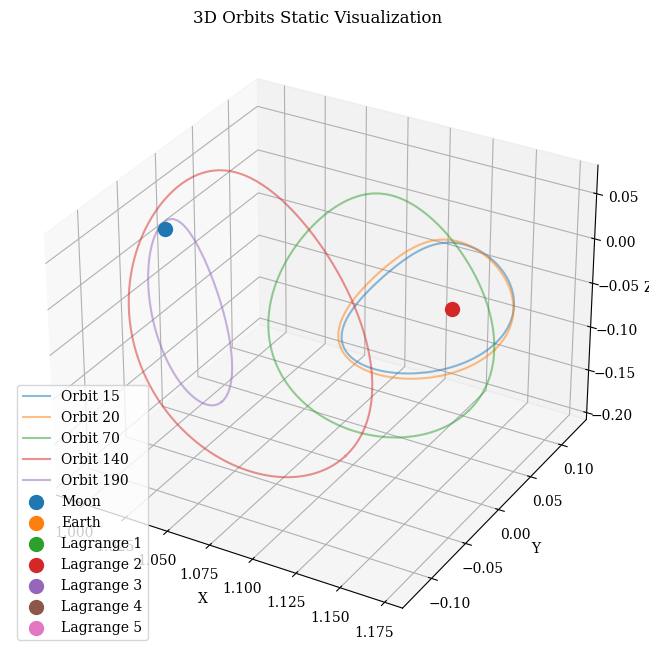

In [43]:
visualize_static_orbits(data= orbit_data, orbit_indices=[15,20,70,140,190], point_dict=EM_POINTS)

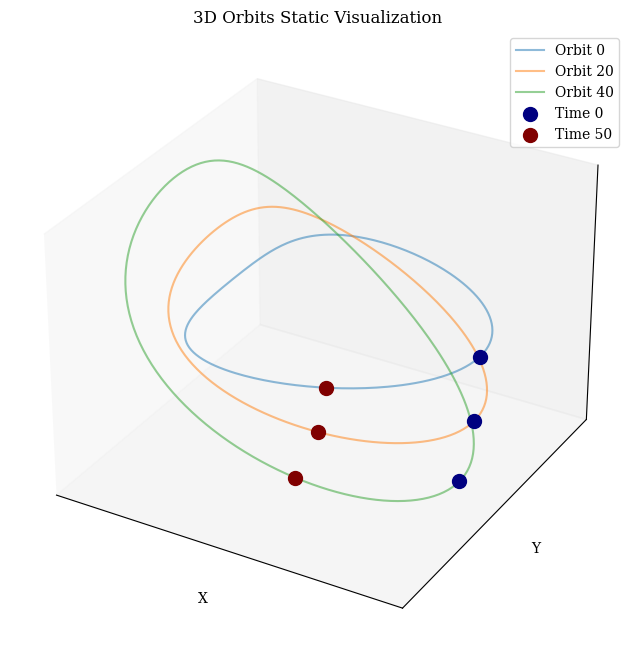

In [44]:
visualize_static_orbits(data= orbit_data,time_instants=[0,50], orbit_indices=[0,20,40], plot_reference_box=False)

In [45]:
#| hide
#| test "invalid time_instants raises ValueError"
time_instants = [-1, 11]  # Out of bounds
with raises(ValueError):
    visualize_static_orbits(orbit_data, time_instants)

#| test "invalid orbit_indices raises ValueError"
time_instants = [0, 9]  # Valid
orbit_indices = [201]  # Out of bounds
with raises(ValueError) as exception_info:
    visualize_static_orbits(orbit_data, time_instants, orbit_indices)
assert "Orbit index 201 is out of range." in str(exception_info.value)

### Dynamic

In [46]:
#| export
def export_dynamic_orbits_html(data: np.ndarray,  # Orbit data as a 3D numpy array (num_orbits, 6, num_time_points).
                               time_instants: Optional[List[int]] = None,  # Time instants to highlight.
                               orbit_indices: Optional[List[int]] = None,  # Indices of orbits to visualize.
                               point_dict: Optional[Dict[str, tuple]] = None,  # Named points as a dict with 3D coordinates.
                               filename: str = 'orbits.html'  # Path and name of the file to save the HTML plot.
                               ) -> None:
    """
    Generates an interactive 3D visualization of orbits and saves it as an HTML file, including the ability to
    highlight specific time instants and show named points.
    """
    if time_instants is None:
        time_instants = []  # Ensure time_instants is initialized if None.

    num_orbits = data.shape[0]  # Total number of orbits in the dataset.
    if orbit_indices is None:
        orbit_indices = list(range(num_orbits))  # Default to visualizing all orbits if none specified.

    fig = go.Figure()  # Initialize the plotly figure.

    # Validate and plot each orbit.
    for index in orbit_indices:
        if index < 0 or index >= num_orbits:
            raise ValueError(f"Orbit index {index} is out of range.")
        
        # Extract coordinates for the plot.
        X = data[index, 0, :]  # X coordinates.
        Y = data[index, 1, :]  # Y coordinates.
        Z = data[index, 2, :]  # Z coordinates.
        fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='lines',
                                   name=f'Orbit {index}',
                                   legendgroup=f'orbit{index}',
                                   showlegend=True))

        # Highlight specific time instants.
        if time_instants:
            for timestamp in time_instants:
                if timestamp < 0 or timestamp >= data.shape[2]:
                    raise ValueError(f"The provided timestamp {timestamp} is out of range.")
                highlight_x = [data[index, 0, timestamp]]
                highlight_y = [data[index, 1, timestamp]]
                highlight_z = [data[index, 2, timestamp]]
                fig.add_trace(go.Scatter3d(x=highlight_x, y=highlight_y, z=highlight_z, mode='markers',
                                           marker=dict(size=5, color='red'),
                                           name=f'Highlight {index} @ {timestamp}',
                                           legendgroup=f'orbit{index}',
                                           showlegend=False))

    # Add additional points from point_dict to the plot.
    if point_dict:
        for point_name, coords in point_dict.items():
            fig.add_trace(go.Scatter3d(x=[coords[0]], y=[coords[1]], z=[coords[2]], mode='markers',
                                       marker=dict(size=5),
                                       name=point_name))

    # Configure the layout of the plot.
    fig.update_layout(title='3D Orbits Visualization',
                      scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      width=800, height=600,
                      legend_title="Orbits Legend",
                      clickmode='event+select')

    # Write the plot to an HTML file.
    fig.write_html(filename)
    print(f"Visualization saved to {filename}")

In [47]:
export_dynamic_orbits_html(data=orbit_data, filename='../data/example_data/example_orbits.html')

Visualization saved to ../data/example_data/example_orbits.html


[View Orbit Visualization](../data/example_orbits.html)


In [48]:
#| hide

#| test "invalid time_instants raises ValueError"
data = np.zeros((3, 6, 50))  # Dummy data with 3 orbits, 6 parameters, 50 time points
time_instants = [-1, 51]  # Invalid time_instants
orbit_indices = [0, 1]  # Valid orbit indices
filename = 'test_orbits.html'  # Filename for saving the HTML
with raises(ValueError):
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)

#| test "invalid orbit_indices raises ValueError"
time_instants = [10, 20]  # Valid time_instants
orbit_indices = [3, 4]  # Invalid orbit indices (out of range for given data)
with raises(ValueError):
    export_dynamic_orbits_html(data, time_instants, orbit_indices, filename=filename)


## Orbit Features

In [49]:
#| export
def plot_grouped_features(df: pd.DataFrame,               # DataFrame containing the data.
                          columns: List[str],             # List of column names to plot.
                          group_col: str,                 # Column name to group by.
                          plot_type: str                  # Type of plot: 'violin', 'box', 'facetgrid', or 'histogram'
                         ) -> None:
    """
    Group the DataFrame by a specified column and plot the specified type of plot for each column for each group.
    """
    if plot_type not in ['violin', 'box', 'facetgrid', 'histogram']:
        raise ValueError("plot_type must be one of 'violin', 'box', 'facetgrid', or 'histogram'")
    
    if plot_type in ['violin', 'box']:
        # Set up the matplotlib figure
        fig, axs = plt.subplots(1, len(columns), figsize=(5 * len(columns), 5))
        
        # If only one column, axs is not an array, so make it an array
        if len(columns) == 1:
            axs = [axs]
        
        # Plot each specified column
        for i, column in enumerate(columns):
            if plot_type == 'violin':
                sns.violinplot(x=group_col, y=column, data=df, ax=axs[i])
                axs[i].set_title(f'Violin plot of {column.capitalize()} by {group_col.capitalize()}')
            elif plot_type == 'box':
                sns.boxplot(x=group_col, y=column, data=df, ax=axs[i])
                axs[i].set_title(f'Box plot of {column.capitalize()} by {group_col.capitalize()}')
            axs[i].set_xlabel(group_col.capitalize())
            axs[i].set_ylabel(column.capitalize())
        
        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()

    elif plot_type == 'facetgrid':
        for column in columns:
            g = sns.FacetGrid(df, col=group_col, col_wrap=4, height=4, sharex=False, sharey=False)
            g.map(plt.hist, column, bins=20, edgecolor='black')
            g.set_axis_labels(column.capitalize(), 'Frequency')
            g.set_titles(col_template=f"{column.capitalize()} | {{col_name}} {group_col}")
            plt.show()

    elif plot_type == 'histogram':
        # Group by the specified column
        grouped = df.groupby(group_col)

        # Plot histograms for each group
        for group_name, group in grouped:
            num_columns = len(columns)
            fig, axs = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5))
            
            # If only one column, axs is not an array, so make it an array
            if num_columns == 1:
                axs = [axs]
            
            # Plot each specified column
            for i, column in enumerate(columns):
                axs[i].hist(group[column], bins=20, edgecolor='black')
                axs[i].set_title(f'{column.capitalize()} for {group_col.capitalize()}: {group_name}')
                axs[i].set_xlabel(column.capitalize())
                axs[i].set_ylabel('Frequency')
                axs[i].grid(True)
            
            # Adjust layout and show the plot
            plt.tight_layout()
            plt.show()

In [50]:
#| export
def plot_value_proportions(data: Optional[Union[List[int], np.ndarray]],  # List or array of ID values to filter the DataFrame.
                           classification_df: pd.DataFrame,               # DataFrame containing the data.
                           id_col_classification: Optional[str] = None,   # Column name to be used as ID.
                           grid: Optional[str] = 'horizontal',            # Option to plot in grid (horizontal, vertical, or square) or separate images.
                           show_percentages: Union[bool, List[bool]] = True, # Option to print or not print percentages.
                           show_labels: Union[bool, List[bool]] = True,      # Option to print or not print labels.
                           percentage_font_size: int = 10,                # Font size for percentages.
                           label_distance: float = 1.1,                   # Distance of labels from center.
                           pct_distance: float = 0.85,                    # Distance of percentages from center.
                           explode_factor: float = 0.1                    # Factor to separate slices.
                          ) -> None:
    """
    Count occurrences of each unique value in data, map those counts to the DataFrame,
    and plot the proportions in pie charts for each column except the ID column.
    """
    if data is not None:
        if isinstance(data, np.ndarray):
            data = data.tolist()
        data_series = pd.Series(data)
        data_counts = data_series.value_counts()
        # Map counts to the DataFrame
        if id_col_classification:
            labels = classification_df.set_index(id_col_classification).loc[data_series].index
        else:
            labels = classification_df.loc[data_series.index].index
    else:
        labels = classification_df.index

    label_counts = pd.Series(labels).value_counts()

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return f'{pct:.1f}%' if show_percentages else None
        return my_autopct

    columns_to_plot = [col for col in classification_df.columns if col != id_col_classification]
    num_cols = len(columns_to_plot)
    alphabet = 'abcdefghijklmnopqrstuvwxyz'

    # Handle list or single boolean for show_percentages and show_labels
    if isinstance(show_percentages, bool):
        show_percentages = [show_percentages] * num_cols
    if isinstance(show_labels, bool):
        show_labels = [show_labels] * num_cols

    def plot_pie(ax, values, title, idx, show_pct, show_lbl):
        explode = [explode_factor] * len(values)
        autopct = make_autopct(values) if show_pct else None
        labels = values.index if show_lbl else None
        ax.pie(values, labels=labels, autopct=autopct, startangle=140,
               textprops={'fontsize': percentage_font_size}, labeldistance=label_distance if show_lbl else None,
               pctdistance=pct_distance if show_pct else None, explode=explode)
        ax.set_title(f'{alphabet[idx]}) {title}')
        ax.axis('equal')
        total_classes = len(values)
        ax.text(0, 0, str(total_classes), ha='center', va='center', fontsize=12, weight='bold')

    if grid == 'horizontal':
        fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 6, 6))
        axes = np.atleast_1d(axes)  # Ensure axes is always an array, even with a single subplot
        for i, column in enumerate(columns_to_plot):
            values = classification_df[column].reindex(labels).value_counts()
            plot_pie(axes[i], values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
        plt.tight_layout()
        plt.show()
    elif grid == 'vertical':
        fig, axes = plt.subplots(num_cols, 1, figsize=(6, num_cols * 6))
        axes = np.atleast_1d(axes)  # Ensure axes is always an array, even with a single subplot
        for i, column in enumerate(columns_to_plot):
            values = classification_df[column].reindex(labels).value_counts()
            plot_pie(axes[i], values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
        plt.tight_layout()
        plt.show()
    elif grid == 'square':
        grid_size = int(np.ceil(np.sqrt(num_cols)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 6, grid_size * 6))
        axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier
        for i, column in enumerate(columns_to_plot):
            values = classification_df[column].reindex(labels).value_counts()
            plot_pie(axes[i], values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
    else:
        for i, column in enumerate(columns_to_plot):
            plt.figure(figsize=(6, 6))
            values = classification_df[column].reindex(labels).value_counts()
            ax = plt.gca()
            plot_pie(ax, values, f'Proportion of orbits by {column}', i, show_percentages[i], show_labels[i])
            plt.show()

## Latent Space

In [51]:
#| export
def plot_latent_space_2d(latent_representations: np.ndarray,  # Precomputed latent representations (numpy array).
                         labels: np.ndarray,                  # Labels for the data points, used for coloring in the plot.
                         figsize: tuple = (12, 9),            # Size of the figure for the plot.
                         save_path: Optional[str] = None,     # Optional path to save the plot image.
                         many_classes: bool = False,          # Flag to use enhanced plotting for many classes.
                         **kwargs: Any                        # Additional keyword arguments for the plotting.
                        ) -> None:
    """
    Plots and optionally saves the latent space representations assuming they are already in 2D.
    """
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_

    # Use a colormap for better color differentiation
    cmap = cm.get_cmap('tab20', len(class_names))  # You can change 'tab20' to any other colormap
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']  # Marker styles
    fig, ax = plt.subplots(figsize=figsize)

    if many_classes:
        for class_idx, class_name in enumerate(class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx)
            marker = markers[class_idx % len(markers)]
            ax.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                       label=class_name, marker=marker, color=color, s=30, **kwargs)
        ax.legend(title="Classes")
    else:
        unique_labels = np.unique(encoded_labels)
        for class_idx, class_name in zip(unique_labels, class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx)
            ax.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                       label=class_name, color=color, s=30, **kwargs)
        ax.legend(title="Classes")

    ax.set_title('2D Latent Space Visualization')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    plt.show()

In [52]:
#| export
def plot_combined_latent_space_2d(
        real_data: np.ndarray,                    # Real data samples.
        synthetic_data: np.ndarray,               # Synthetic data samples generated by a model.
        encoder,                                  # Encoder function or model that predicts latent space representations.
        synthetic_labels: Optional[Union[int, List[int]]] = 1,  # Labels for synthetic data. Can be a single label or a list of labels.
        figsize: tuple = (12, 9),                 # Size of the figure.
        save_path: Optional[str] = None,          # Optional path to save the plot image.
        many_classes: bool = False,               # Flag to use enhanced plotting for many classes.
        show_legend: bool = True,                 # Flag to show or hide the legend.
        annotation_mode: str = 'legend'           # Mode for annotation: 'legend' for colored dots, 'numbers' for numeric annotations.
    ) -> None:
    """
    Plots the combined latent space of real and synthetic data.
    Assumes the latent space is already 2D.
    """
    # Concatenate real and synthetic data
    combined_data = np.concatenate([real_data, synthetic_data], axis=0)

    # Create labels for real and synthetic data
    real_labels = np.zeros(real_data.shape[0], dtype=int)
    if isinstance(synthetic_labels, int):
        synthetic_labels = np.full(synthetic_data.shape[0], synthetic_labels, dtype=int)
    synthetic_labels = np.array(synthetic_labels)
    combined_labels = np.concatenate([real_labels, synthetic_labels], axis=0)

    # Generate latent representations for the combined dataset
    latent_representations = encoder.predict(combined_data)

    # Handle case where encoder returns a tuple or list
    if isinstance(latent_representations, (list, tuple)):
        latent_representations = latent_representations[0]  # Assuming the first element is the required representation

    # Convert latent_representations to a NumPy array if it is a list
    latent_representations = np.array(latent_representations)

    # Ensure the latent space is 2D
    assert latent_representations.shape[1] == 2, "The latent space representations must be 2D."

    # Create a color map with enough colors
    cmap = plt.get_cmap('tab20', len(np.unique(combined_labels)))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(np.unique(combined_labels))+1)-0.5, ncolors=len(np.unique(combined_labels)))

    # Plotting
    plt.figure(figsize=figsize)
    scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=combined_labels, cmap=cmap, norm=norm, alpha=0.7)
    
    if annotation_mode == 'legend' and show_legend:
        # Create custom legend
        unique_labels = np.unique(combined_labels)
        custom_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(label)), markersize=10) for label in unique_labels]
        custom_labels = ["Real"] + [f"Synthetic {label}" for label in np.unique(synthetic_labels)]
        plt.legend(custom_handles, custom_labels, title="Classes", loc='upper right')  # Place legend in the upper right corner
    
    elif annotation_mode == 'numbers':
        # Annotate only synthetic points with their class labels
        for i in range(real_data.shape[0], combined_data.shape[0]):
            plt.annotate(combined_labels[i], (latent_representations[i, 0], latent_representations[i, 1]), fontsize=9, alpha=0.7)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [53]:
#| export
def plot_latent_space_with_feature_distributions(latent_representations: np.ndarray,    # Precomputed latent representations (numpy array).
                                                 labels: np.ndarray,                    # Labels for the data points, used for coloring in the plot.
                                                 features: Optional[np.ndarray] = None, # Additional features for distribution plotting.
                                                 feature_names: Optional[list] = None,  # Names of the features for labeling.
                                                 figsize: tuple = (12, 9),              # Size of the figure for the plot.
                                                 save_path: Optional[str] = None,       # Optional path to save the plot image.
                                                 many_classes: bool = False,            # Flag to use enhanced plotting for many classes.
                                                 show_legend: bool = True,              # Flag to show/hide legends.
                                                 **kwargs: Any                          # Additional keyword arguments for the plotting.
                                                ) -> None:
    """
    Plots the latent space with class colors and normalized vertical and horizontal feature distributions in separate subplots.
    """
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_

    # Use a colormap for better color differentiation
    cmap = colormaps.get_cmap('tab20')  # You can change 'tab20' to any other colormap
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']  # Marker styles

    # Create subplots
    fig = plt.figure(figsize=(figsize[0], figsize[1] * 1.5))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], width_ratios=[10, 2])

    ax1 = fig.add_subplot(gs[0, 0])  # Latent space plot
    ax2 = fig.add_subplot(gs[1, 0])  # Horizontal distribution plot
    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1)  # Vertical distribution plot

    # Plot the latent representations with class colors
    if many_classes:
        for class_idx, class_name in enumerate(class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx / len(class_names))
            marker = markers[class_idx % len(markers)]
            ax1.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                        label=class_name, marker=marker, color=color, s=30, **kwargs)
    else:
        unique_labels = np.unique(encoded_labels)
        for class_idx, class_name in zip(unique_labels, class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx / len(class_names))
            ax1.scatter(latent_representations[class_mask, 0], latent_representations[class_mask, 1],
                        label=class_name, color=color, s=30, **kwargs)

    ax1.set_title('2D Latent Space Visualization')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    if show_legend:
        ax1.legend(title="Classes")

    if features is not None and feature_names is not None:
        # Horizontal distribution
        x_min, x_max = np.min(latent_representations[:, 0]), np.max(latent_representations[:, 0])
        x_bins = np.linspace(x_min, x_max, 100)

        for feature_index, feature_name in enumerate(feature_names):
            feature_values = features[:, feature_index]
            avg_feature_values = []

            for i in range(len(x_bins) - 1):
                mask = (latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1])
                avg_feature_values.append(np.mean(feature_values[mask]) if np.sum(mask) > 0 else 0)

            avg_feature_values = np.array(avg_feature_values)
            # Normalize the feature values
            avg_feature_values = (avg_feature_values - np.min(avg_feature_values)) / (np.max(avg_feature_values) - np.min(avg_feature_values) + 1e-8)
            # Plot the normalized distributions
            ax2.plot((x_bins[:-1] + x_bins[1:]) / 2, avg_feature_values, label=f'{feature_name} distribution')

        ax2.set_title('Normalized Horizontal Feature Distributions')
        ax2.set_xlabel('Dimension 1')
        ax2.set_ylabel('Normalized Feature Value')
        if show_legend:
            ax2.legend()

        # Vertical distribution
        y_min, y_max = np.min(latent_representations[:, 1]), np.max(latent_representations[:, 1])
        y_bins = np.linspace(y_min, y_max, 100)

        for feature_index, feature_name in enumerate(feature_names):
            feature_values = features[:, feature_index]
            avg_feature_values = []

            for i in range(len(y_bins) - 1):
                mask = (latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1])
                avg_feature_values.append(np.mean(feature_values[mask]) if np.sum(mask) > 0 else 0)

            avg_feature_values = np.array(avg_feature_values)
            # Normalize the feature values
            avg_feature_values = (avg_feature_values - np.min(avg_feature_values)) / (np.max(avg_feature_values) - np.min(avg_feature_values) + 1e-8)
            # Plot the normalized distributions
            ax3.plot(avg_feature_values, (y_bins[:-1] + y_bins[1:]) / 2, label=f'{feature_name} distribution')

        ax3.set_title('Normalized Vertical Feature Distributions')
        ax3.set_xlabel('Normalized Feature Value')
        ax3.set_ylabel('Dimension 2')
        if show_legend:
            ax3.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    plt.show()

In [54]:
#| hide
import nbdev; nbdev.nbdev_export()